## Preprocessing the data

Create a TimeSeries object from a Pandas DataFrame, and split it in train/validation series:

In [10]:
import pandas as pd
from darts import TimeSeries

# Read a pandas DataFrame 2023
load2023 = pd.read_csv("Load_Data/Total Load - Day Ahead _ Actual_2023.csv", delimiter=",")

# Change the timestamp following the dataseries for DARTS
load2023['Time (UTC)'] = load2023['Time (UTC)'].str.split(' - ').str[0]
# Delete the initial day ahead forecast data
load2023 = load2023.drop('Day-ahead Total Load Forecast [MW] - BZN|SE3',axis=1)   
# Change the name to simple name
load2023 = load2023.rename(columns={'Time (UTC)': 'completetime', 'Actual Total Load [MW] - BZN|SE3': 'Load [MW]'})
# Convert 'time' to datetime for easier splitting
load2023['datetime'] = pd.to_datetime(load2023['completetime'], format='%d.%m.%Y %H:%M')
#load2023['completetime'] = load2023['datetime'].dt.strftime('%Y-%m-%d %H:%M')
# Create 'date' and 'time' columns
#load2023['date'] = load2023['datetime'].dt.strftime('%Y-%m-%d')
# load2023['time'] = load2023['datetime'].dt.strftime('%H:%M:%S')
load2023 = load2023.drop(['completetime'], axis=1)
# Reorder the column
load2023 = load2023[['datetime', 'Load [MW]']]

print(load2023)




                datetime  Load [MW]
0    2023-01-01 00:00:00       8943
1    2023-01-01 01:00:00       8929
2    2023-01-01 02:00:00       8887
3    2023-01-01 03:00:00       8859
4    2023-01-01 04:00:00       8880
...                  ...        ...
8755 2023-12-31 19:00:00      11561
8756 2023-12-31 20:00:00      11276
8757 2023-12-31 21:00:00      11035
8758 2023-12-31 22:00:00      10831
8759 2023-12-31 23:00:00      10722

[8760 rows x 2 columns]


Adding features to this dataset can help us better understand it. Let's start with some simple calendar features like day of week and time of day. 

In [11]:
load2023 = load2023.reset_index(drop=True)
load2023['Day_of_week'] = load2023['datetime'].dt.dayofweek
load2023['Hour_of_day'] = load2023['datetime'].dt.hour
load2023 = load2023.set_index('datetime')
load2023

,Load [MW],Day_of_week,Hour_of_day
datetime,,,
2023-01-01 00:00:00,8943,6,0
2023-01-01 01:00:00,8929,6,1
2023-01-01 02:00:00,8887,6,2
2023-01-01 03:00:00,8859,6,3
2023-01-01 04:00:00,8880,6,4
...,...,...,...
2023-12-31 19:00:00,11561,6,19
2023-12-31 20:00:00,11276,6,20
2023-12-31 21:00:00,11035,6,21


In [ ]:
# Create a TimeSeries, specifying the time and value columns
series = TimeSeries.from_dataframe(load2023, "datetime", "Load [MW]")

# Set aside the last 3 months as a validation series
train, val = series[:-2209], series[-2209:]

Fit an exponential smoothing model, and make a (probabilistic) prediction over the validation series’ duration:

In [ ]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

c:\Users\jakfa\Documents\Project\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Plot the median, 5th and 95th percentiles:

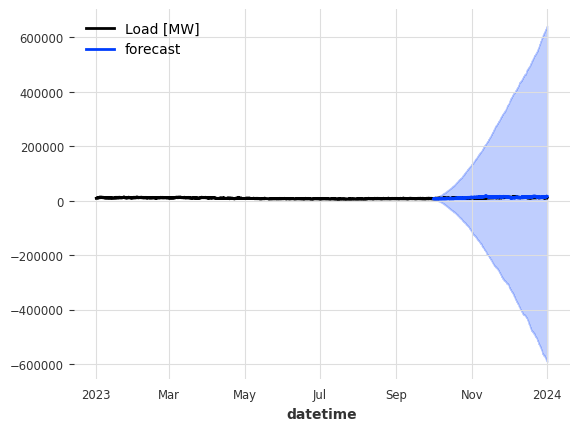

In [ ]:
import matplotlib.pyplot as plt

series.plot()
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()